# Cataclysmic Variable (CV) Classification Using MESA Simulation Data

This Jupyter Notebook provides a structured guide for classifying **Cataclysmic Variables (CVs)** based on binary star evolution data generated through the **Modules for Experiments in Stellar Astrophysics (MESA)** code. This notebook is based on methods and datasets developed in Putra & Putra (in preparation), which explores the formation and present-day population of CVs using a grid of binary evolution models computed with MESA.


In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

## The Binary Evolution Dataset

The dataset is organized in a directory named `MESA_COMPILED`, containing binary star evolution data produced by MESA. This dataset captures the evolutionary outcomes of a large number of binary systems at various stages. The primary goal is to determine which systems are in a CV phase at a given age.

### Folder Structure

- `MESA_COMPILED/`
  - `_legend.txt`: A metadata file that provides the correspondence between an index `i` and a specific evolutionary age in years. It contains two columns:
    - `i`: File index (integer)
    - `age`: Age of the evolution in years (float)
    
    For example:
    ```
    i       age
    7   3512973430.827586
    ```
    indicates that the file `MESA_COMPILED_7.txt` contains data for systems evaluated at 3.51 Gyr.

  - `MESA_COMPILED_i.txt`: A set of files indexed by `i` (from `_legend.txt`). Each file contains simulation results for binary systems at the corresponding evolutionary age. The files are named accordingly, e.g., `MESA_COMPILED_7.txt` corresponds to age = 3.51 Gyr.

### Data File Format

Each `MESA_COMPILED_i.txt` file contains a table with 7 columns:

| Column     | Description                                                                 |
|------------|-----------------------------------------------------------------------------|
| `i`        | Model index (a unique ID for the simulation run; **not** the same as in `_legend.txt`) |
| `M1`       | Initial mass of the primary star (i.e., the white dwarf progenitor), in $M_\odot$ |
| `Pi`       | Initial orbital period of the binary system, in days                        |
| `M2`       | Initial mass of the secondary star, in $M_\odot$                            |
| `MWD`      | Mass of the white dwarf at the specified evolutionary age, in $M_\odot$         |
| `Pf`       | Orbital period at the specified evolutionary age, in days                       |
| `CV?`      | Classification status: `"yes"` if the system is a CV at the given age, `"no"` otherwise |

This structure allows users to explore how different initial binary configurations evolve over time, and to identify which systems become Cataclysmic Variables.

### Loading the Dataset

First, we load the binary evolution dataset from the `MESA_COMPILED` directory. This includes reading the simulation outputs at different evolutionary ages and organizing them into structured arrays for further analysis.

* `age_mesa`: 1D NumPy array of evolutionary ages (in years), as specified in `_legend.txt`.
* `M1_mesa`, `Pi_mesa`, `M2_mesa`, `MW_mesa`, `Pf_mesa`, `CV_mesa`: 2D arrays containing the evolution data.

  * Each row corresponds to a specific age (`MESA_COMPILED_i.txt`).
  * Each column corresponds to a distinct binary system model at that age.

The function `load_mesa_data()` handles this process automatically.

In [2]:
def load_mesa_data(foldload):
    os.makedirs(foldload, exist_ok=True)
    file_count = sum(1 for file in os.listdir(foldload) if file.startswith(foldload) and os.path.isfile(os.path.join(foldload, file)))
    M1 = []
    Pi = []
    M2 = []
    Mw = []
    Pf = []
    CV = []
    for i in tqdm(range(file_count)):
        pops = pd.read_csv(foldload+'/'+foldload+'_'+str(i)+'.txt', sep="\t", header=0)
        m1 = pops["M1"]
        m2 = pops["M2"]
        mw = pops["MWD"]
        pi = pops["Pi"]
        pf = pops["Pf"]
        cv = pops["CV?"]
        M1.append(m1)
        M2.append(m2)
        Mw.append(mw)
        Pi.append(pi)
        Pf.append(pf)
        CV.append(cv)
    age = pd.read_csv(foldload+"/"+"_legend.txt", sep='\t', header=0)
    age = age["age"].to_numpy()
    return age, np.array(M1), np.array(Pi), np.array(M2), np.array(Mw), np.array(Pf), np.array(CV)

In [3]:
age_mesa, M1_mesa, Pi_mesa, M2_mesa, MW_mesa, Pf_mesa, CV_mesa = load_mesa_data("MESA_COMPILED")

100%|█████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 528.60it/s]


Before proceeding, let's perform a brief inspection of the loaded dataset. This helps verify the integrity of the data and provides context for the physical parameters of the binary systems.

We begin by displaying a few example age windows and then preview the physical parameters of all systems at a selected window.


In [4]:
print(f"Total number of age snapshots: {len(age_mesa)}")
print("Example ages (in years):", age_mesa[:5], "...")

# Select an index to preview data (e.g., the 10th window)
preview_index = 10
print(f"\nPreviewing data at age ≈ {age_mesa[preview_index]:.2e} years")

df_preview = pd.DataFrame({
    "M1 [Msun]": M1_mesa[preview_index],
    "Pi [days]": Pi_mesa[preview_index],
    "M2 [Msun]": M2_mesa[preview_index],
    "MWD [Msun]": MW_mesa[preview_index],
    "Pf [days]": Pf_mesa[preview_index],
    "CV?": CV_mesa[preview_index]
})

df_preview.head()


Total number of age snapshots: 29
Example ages (in years): [4.30045224e+08 8.70463539e+08 1.31088185e+09 1.75130017e+09
 2.19171848e+09] ...

Previewing data at age ≈ 4.83e+09 years


,M1 [Msun],Pi [days],M2 [Msun],MWD [Msun],Pf [days],CV?
0,1.0,50.0,0.20,0.321676,0.041410,yes
1,1.0,50.0,0.25,0.321021,0.052166,yes
2,1.0,50.0,0.30,0.320768,0.065344,yes
3,1.0,87.0,0.10,inf,inf,no
4,1.0,87.0,0.15,0.341342,0.048998,yes


You may notice that some entries in the `MWD` and `Pf` columns contain `inf` or `NaN` values. These are **not errors**, but intentional artifacts resulting from the interpolation process used to compile this dataset from raw MESA simulation outputs.

These cases typically represent one of the following physical scenarios:

- The binary model **did not successfully pass through the common envelope phase** (or at least not yet in that age window), and thus no meaningful post-CE parameters (like `MWD` or `Pf`) can be computed.
- The binary system has effectively **ceased to be a viable CV** at the given age window — for example, the secondary star may have become too low in mass (or already dead, for short).

Such systems can be safely **ignored**, especially in CV classification tasks as the data already flagged "no". You may apply a mask later on if you wish to get the `MWD` and `Pf` values, but that would not be the case for now.|

## Model Fitting

We build a simple machine learning classifier to predict whether a binary system becomes a CV at a given Galactic age window, based on its physical parameters. We will use **TensorFlow**, a widely-used open-source library for numerical computation and machine learning, particularly well-suited for deep learning applications.

To keep things interpretable and computationally light, we incorporate:

* Three **Dense layers** with 2 hidden layers
* **Linear activation** and **Binary cross-entropy loss fucntion** with logits
* **Adam Algorithm** for the learning rate determination
* Finding the best starting learning rate value through loop

In [5]:
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Normalization
from tensorflow.keras.losses import BinaryCrossentropy

### Preparing The Dataset

Before training, we must restructure the dataset into a format suitable for TensorFlow:

* Each **data point** will be a NumPy array of features:
  `X = [age, M1, M2, Pi]`
* Each **label** will be a binary indicator:
  `Y = [1]` if the system is a CV, `0` otherwise

First, flatten the data arrays: `(n_window, n_model) → (n_window * n_model,)`

In [6]:
age_flat = np.repeat(age_mesa[:, np.newaxis], M1_mesa.shape[1], axis=1).flatten()
M1_flat = M1_mesa.flatten()
M2_flat = M2_mesa.flatten()
Pi_flat = Pi_mesa.flatten()
CV_flat = CV_mesa.flatten()

And then, lets convert `CV?` labels to binary: `yes` → 1, `no` → 0 and combine all features into `X` and `Y` arrays.

In [7]:
X = np.vstack([age_flat, M1_flat, M2_flat, Pi_flat]).T
Y = np.array([1 if x == 'yes' else 0 for x in CV_flat])

Before fitting the model, it is useful to inspect the structured dataset that will be passed to TensorFlow. The input features include the system's evolutionary age and initial physical parameters, while the target label indicates whether the system is classified as a CV.

The preview below shows the first few entries of the training dataset:

* **Features**: Age, primary mass (M1), secondary mass (M2), and initial orbital period (Pi)
* **Label**: `CV?`, converted to binary (1 = CV, 0 = not a CV)


In [8]:
df_tf_preview = pd.DataFrame(X, columns=["Age [yr]", "M1 [Msun]", "M2 [Msun]", "Pi [days]"])
df_tf_preview["CV?"] = Y

print(f"Total training data points: {X.shape[0]}")
df_tf_preview.head(10)

Total training data points: 2436


,Age [yr],M1 [Msun],M2 [Msun],Pi [days],CV?
0,4.300452e+08,1.0,0.20,50.0,1
1,4.300452e+08,1.0,0.25,50.0,0
2,4.300452e+08,1.0,0.30,50.0,0
3,4.300452e+08,1.0,0.10,87.0,0
4,4.300452e+08,1.0,0.15,87.0,0
5,4.300452e+08,1.0,0.20,87.0,0
6,4.300452e+08,1.0,0.25,87.0,0
7,4.300452e+08,1.0,0.30,87.0,0
8,4.300452e+08,1.0,0.10,149.0,0
9,4.300452e+08,1.0,0.15,149.0,0


### Handling Class Imbalance with Weighted Loss

Before we train the machine learning model, it’s helpful to visually explore how the CV classification depends on different physical properties across time. We arbitrarily isolate systems with initial primary mass $M_2 = 1.3 \mathrm{M_\odot}$ and compare their orbital and secondary star configurations at three different evolutionary ages. For each of these, we plot $P_i$ vs $M_2$, color-coded by whether the system becomes a CV at that age window.

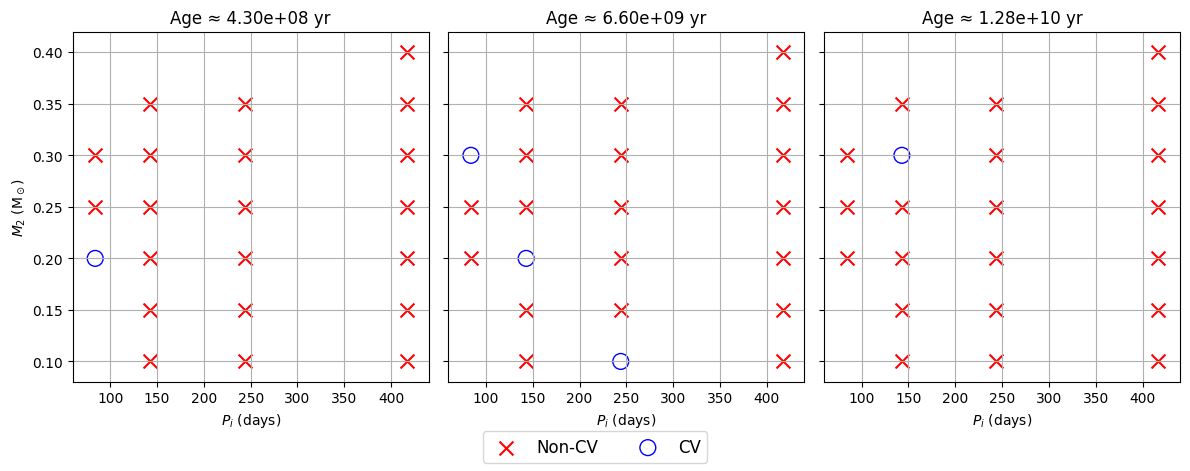

In [9]:
indices = [0, len(age_mesa)//2, len(age_mesa)-1]
fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True)

for idx, ax in zip(indices, axes):
    mask = (np.abs(M1_mesa[idx] - 1.3) < 0.01)
    
    m2 = M2_mesa[idx][mask]
    pi = Pi_mesa[idx][mask]
    cv = CV_mesa[idx][mask]
    cv_binary = np.array([True if x == 'yes' else False for x in cv])
    m2_cv = m2[cv_binary]
    pi_cv = pi[cv_binary]
    m2_no = m2[np.invert(cv_binary)]
    pi_no = pi[np.invert(cv_binary)]

    ax.scatter(pi_cv, m2_cv, facecolors='none', edgecolors='b', marker='o', s=130)
    ax.scatter(pi_no, m2_no, c='r', marker='x', s=100)
    ax.set_title(f"Age ≈ {age_mesa[idx]:.2e} yr")
    ax.set_xlabel(r"$P_i$ (days)")
    ax.set_xlim(60,440)
    ax.set_ylim(0.08,0.42)
    ax.grid(True)

axes[0].set_ylabel(r"$M_2$ ($\mathrm{M_\odot}$)")
handles = [plt.scatter([0], [0], c='r', marker='x', s=100, label='Non-CV'),
           plt.scatter([0], [0], facecolors='none', edgecolors='b', marker='o', s=130, label='CV')]
fig.legend(handles=handles, loc="lower center", ncol=2, fontsize=12)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()


As we've seen in the previous plots, **CV systems are extremely underrepresented** compared to non-CV systems. To address this, we apply **class weighting**, which tells the model to "care more" about correctly classifying the rarer CV examples. We compute the class weights using `sklearn.class_weight`.


In [10]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Y),
    y=Y
)
class_weights_dict = {i : w for i, w in enumerate(class_weights)}
print(class_weights_dict)

{0: 0.6163967611336032, 1: 2.6478260869565218}


This `class_weights_dict` will be passed into the `.fit()` method of the TensorFlow model to **balance the training loss function**.

### Splitting Data: Training vs. Cross-Validation Set

Before training a machine learning model, it is crucial to evaluate its ability to generalize to unseen data. One common and effective approach is to split the available data into two subsets:

* **Training Set (`X_train`, `Y_train`)**: Used to fit the model.
* **Cross-Validation Set (`X_cv`, `Y_cv`)**: Used to evaluate the model's performance on unseen data during the tuning process, such as testing different learning rates.

This process is essential because models can easily overfit the training data, learning patterns that do not generalize well. The cross-validation set acts as a proxy for future test data, giving us a fairer assessment of how the model is likely to perform in practice.

We perform the split using `sklearn.train_test_split()`

In [11]:
X_train, X_cv, Y_train, Y_cv = train_test_split(X, Y, test_size=0.20, random_state=42)

By setting `random_state=42`, we ensure the split is **reproducible** across runs.

Later, we will use this split to **test different learning rates** and select the one that minimizes validation loss—an essential step for stable and efficient model training.

### Feature Normalization

Lets preview the structure of the reformatted training dataset.

In [12]:
df_tf_preview = pd.DataFrame(X_train, columns=["Age [yr]", "M1 [Msun]", "M2 [Msun]", "Pi [days]"])
df_tf_preview["CV?"] = Y_train

print(f"Total training data points: {X.shape[0]}")
df_tf_preview.head()

Total training data points: 2436


,Age [yr],M1 [Msun],M2 [Msun],Pi [days],CV?
0,1.011925e+10,1.0,0.35,257.0,0
1,1.144050e+10,2.0,0.40,232.0,0
2,8.357575e+09,1.0,0.30,257.0,0
3,1.751300e+09,1.3,0.30,417.0,0
4,1.011925e+10,5.0,0.40,793.0,0


From this preview, perhaps you already noticed immediately before that the **magnitude of the features is highly imbalanced**. i.e.:

* Stellar ages are on the order of billions,
* Masses are typically fractional,
* Orbital periods are in the range of tens to hundreds of days.

Such scale differences can severely impact the training process of neural networks, especially when using gradient-based optimizers. Features with large ranges can dominate the training dynamics, leading to unstable or suboptimal convergence.

To address this, we apply feature normalization, which scales all input features to comparable magnitudes. TensorFlow provides a convenient utility via `tf.keras.layers.Normalization()`

In [13]:
normalizer = Normalization()
normalizer.adapt(X_train)
X_train_norm = normalizer(X_train)
X_cv_norm = normalizer(X_cv)

Lets review the normalized dataset.

In [14]:
df_tf_preview = pd.DataFrame(X_train_norm, columns=["Age [yr]", "M1 [Msun]", "M2 [Msun]", "Pi [days]"])
df_tf_preview["CV?"] = Y_train

print(f"Total training data points: {X.shape[0]}")
df_tf_preview.head()

Total training data points: 2436


,Age [yr],M1 [Msun],M2 [Msun],Pi [days],CV?
0,0.935854,-0.769211,-0.095737,-0.442085,0
1,1.293197,-0.315308,0.118872,-0.505200,0
2,0.459397,-0.769211,-0.310346,-0.442085,0
3,-1.327318,-0.633040,-0.310346,-0.038154,0
4,0.935854,1.046399,0.118872,0.911085,0


### Model Architecture

We will utilize a sequential neural network model designed to replicate the classification output of the MESA simulation. The architecture was chosen to provide sufficient capacity to learn the complex relationship between the input features and the binary output, while avoiding unnecessary complexity.

The model structure is as follows:

1.  **Input and Normalization:** The `normalizer` layer handles feature scaling, preparing the data for the neural network.
2.  **Hidden Layers (L1 and L2):**
    *   Two fully connected (`Dense`) hidden layers are used.
    *   The first hidden layer (`L1`) has 64 neurons.
    *   The second hidden layer (`L2`) has 32 neurons.
    *   Both layers use the ReLU (`activation='relu'`) activation function, a common choice for hidden layers due to its computational efficiency and ability to help the model learn non-linear patterns.
    *   These layer sizes were selected after experimentation to provide adequate representational power for the physics function without being excessively large, which can sometimes make training harder or slower.
3.  **Output Layer (L3):**
    *   The final layer is a `Dense` layer with 1 neuron. This is standard for binary classification tasks where we need a single output value (either a probability or a raw score).
    *   Crucially, this layer uses a linear (`activation='linear'`) activation function. This means the layer outputs the raw, unscaled sum of its inputs, known as a `logit`, rather than a probability between 0 and 1 (which a sigmoid activation would produce).

In [15]:
model = Sequential([
    normalizer,
    Dense(64, activation = 'relu', name = 'L1'),
    Dense(32, activation = 'relu', name = 'L2'),
    Dense(1, activation = 'linear', name='L3')
])

### Model Compilation

To prepare the model for training, we define the optimizer, loss function, and metrics.

We use the Adam optimizer, a popular choice known for its efficiency.

For binary classification, the standard loss function is Binary Crossentropy. Since our model's output layer has a `linear` activation (outputting logits), we must set `from_logits=True` in the `BinaryCrossentropy` loss function.

*   Using `from_logits=True` tells the loss function to expect the raw logit values directly from the model's output layer.
*   The loss function then internally handles the conversion of these logits into probabilities (using a sigmoid function) before calculating the cross-entropy loss.
*   This approach (linear output + `BinaryCrossentropy(from_logits=True)`) is generally more numerically stable than using a sigmoid activation in the output layer and `BinaryCrossentropy` without `from_logits=True`, especially when dealing with potential floating-point issues during training.

We also monitor accuracy during training, which is calculated correctly by TensorFlow even when using logits and `from_logits=True` for the loss.

In [16]:
model.compile(
    optimizer='adam',
    loss=BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

### Model Training with Early Stopping

Now that the model is compiled, we can train it using the `model.fit()` method.

During training, we will monitor the model's performance on both the training data and the separate validation data (`X_cv`, `Y_cv`). The validation data serves as a proxy for unseen data, helping us evaluate how well the model is generalizing.

A crucial technique used here is Early Stopping, implemented as a Keras Callback. Early Stopping helps to prevent prolonged training that might lead to the model overly specializing in the training data without improving performance on unseen examples (though in our physics simulation context, it helps find the epoch with the highest performance on our validation samples of the deterministic function).

The Early Stopping callback is configured with the following parameters:

*   `monitor='val_accuracy'`: We monitor the model's accuracy on the validation dataset at the end of each epoch.
*   `mode='max'`: We are looking for the *maximum* value of `val_accuracy`. Early Stopping will trigger when the validation accuracy stops improving.
*   `patience=100`: Training will stop if the `val_accuracy` does not improve for 100 consecutive epochs. A higher patience value is used here to account for potential fluctuations in validation accuracy during training and ensure the model has ample opportunity to find its best state.
*   `restore_best_weights=True`: After training stops, the model's weights will be reset to the state from the epoch where the `val_accuracy` was at its highest value recorded during the entire training run. This ensures we get the model that performed best on the validation data.

We will train for a maximum of `epochs=1000`, but Early Stopping will likely halt the process earlier based on the validation performance.

We also include the `class_weight` argument, which was calculated previously (`class_weights_dict`), to help the model better handle the data imbalance by giving more importance to samples from the minority class during the training process.

In [17]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=100,
    restore_best_weights=True
)

print("Fitting...")

history = model.fit(
    X_train, Y_train,
    validation_data=(X_cv, Y_cv),
    epochs=1000,
    class_weight=class_weights_dict,
    callbacks=[early_stopping],
    verbose=0
)

print("Done")

Fitting...
Done


## Model Evaluation

### Report

After training, we evaluate the performance of the best model found by Early Stopping on our evaluation dataset (presumably represented by `X` and `Y` in this code cell).

We will use the standard Classification Report from scikit-learn to get a detailed breakdown of the model's performance metrics for each class (Class 0 and Class 1).

To obtain the final binary predictions from our model (which outputs logits), we follow these steps:

1.  Get the raw logit outputs from the trained model using `model.predict()` on the evaluation data (`X`).
2.  Apply the sigmoid function (`tf.sigmoid()`) to convert these logits into probabilities between 0 and 1.
3.  Apply a prediction threshold of **0.5** to these probabilities:
    *   If the predicted probability is 0.5 or higher, we classify the instance as Class 1.
    *   If the predicted probability is below 0.5, we classify the instance as Class 0.

Finally, the `classification_report` will present the results, including:

*   **Precision:** The proportion of instances predicted as a class that were actually that class (accuracy of positive predictions). `Precision = TP / (TP + FP)`
*   **Recall:** The proportion of actual instances of a class that were correctly identified by the model (sensitivity). `Recall = TP / (TP + FN)`
*   **F1-score:** The harmonic mean of Precision and Recall, providing a single metric that balances both. `F1 = 2 * (Precision * Recall) / (Precision + Recall)`
*   **Support:** The number of actual instances of that class in the evaluation dataset.
*   **Accuracy:** The overall proportion of correctly classified instances.
*   **Macro Avg:** The average of the per-class metrics, treating all classes equally.
*   **Weighted Avg:** The average of the per-class metrics, weighted by the support of each class. This is often more representative for imbalanced datasets.

*TP is true positive, FP is false positive, and FN is false negative*

Let's examine the report to understand the model's performance on unseen data with a 0.5 prediction threshold.

In [18]:
from sklearn.metrics import classification_report

Y_pred_logits = model.predict(X)
Y_pred = tf.sigmoid(Y_pred_logits).numpy().flatten()
y_pred = np.array([1 if x >= 0.5 else 0 for x in Y_pred])

print(classification_report(Y, y_pred, digits=4))

77/77 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0     0.9959    0.9757    0.9857      1976
           1     0.9040    0.9826    0.9417       460

    accuracy                         0.9770      2436
   macro avg     0.9499    0.9792    0.9637      2436
weighted avg     0.9785    0.9770    0.9774      2436



The classification report provides a detailed look at the trained model's performance on the evaluation dataset using a prediction threshold of 0.5 applied to the sigmoid probabilities derived from the model's output logits.

*   The overall accuracy of ~0.9 indicates that the model correctly classifies a high percentage of instances in the evaluation set.
*   For Class 0 (Non-CV), the model demonstrates excellent performance with very high Precision , Recall, and F1-score.
*   For Class 1 (CV), the model achieves a high Recall, meaning it successfully identifies almost all actual Class 1 instances. The Precision is lower than Recall, indicating that while it finds most Class 1s, there are some instances incorrectly classified as Class 1 (False Positives for Class 1). The F1-score for Class 1 represents a reasonable balance for this class given the imbalance.

The performance metrics, particularly the high Recall for the minority class and strong overall accuracy, suggest that the model has learned a good approximation of the physics simulation's logic on the available data.

Personally, I am happy with these results as they indicate the model is performing well on this specific evaluation run and provides a good starting point for replicating the simulation's output.

It's crucial to note that due to the inherent randomness in neural network training (e.g., weight initialization, batch shuffling) and potentially different splits of training/validation/evaluation data, running the training process again or using different data splits may lead to slightly different results. So, if the results don't make sense for you, perhaps you need to run the model fitting again.

### Visualization

To better understand how our trained model is performing and what decision boundary it has learned, we visualize its predictions within a specific slice of the input parameter space.

313/313 [==============================] - 1s 2ms/step


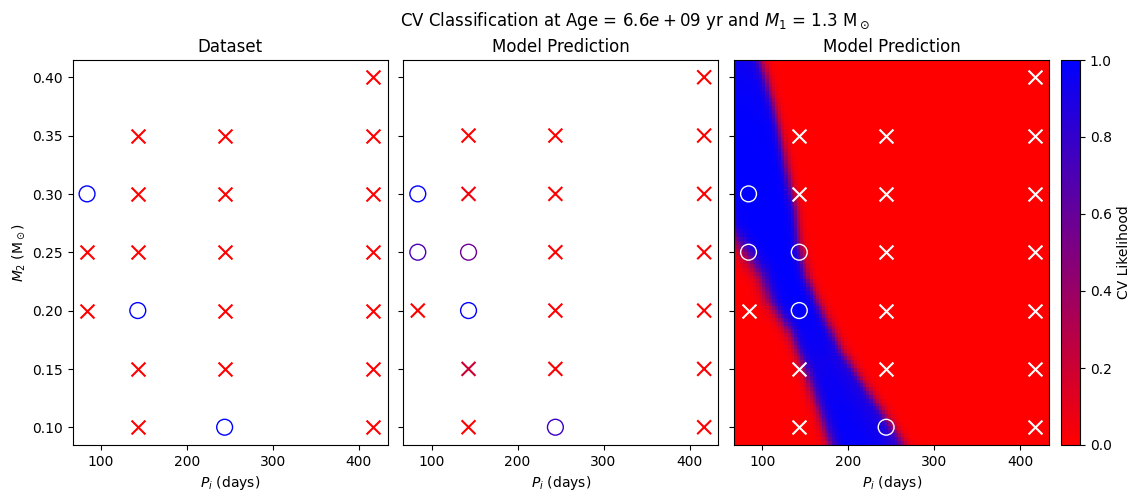

In [19]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap

threshold = 0.5
n = 100 #number of pixel in 1 axis

median_age = age_mesa[len(age_mesa)//2]
M1_target = 1.3
mask = (X[:, 0] == median_age) & (X[:, 1] == M1_target)
X_slice = X[mask]
Y_slice = Y[mask]
cv = np.array([True if x == 1 else False for x in Y_slice])

Y_pred_logits = model.predict(X_slice)
Y_pred = tf.sigmoid(Y_pred_logits).numpy().flatten()
cv_pred =  np.array([True if x >= threshold else False for x in Y_pred])

M2 = X_slice[:, 2]
Pi = X_slice[:, 3]
M2_cv = M2[cv]
Pi_cv = Pi[cv]
M2_no = M2[np.invert(cv)]
Pi_no = Pi[np.invert(cv)]
M2_cv_pred = M2[cv_pred]
Pi_cv_pred = Pi[cv_pred]
M2_no_pred = M2[np.invert(cv_pred)]
Pi_no_pred = Pi[np.invert(cv_pred)]
Y_cv_pred = Y_pred[cv_pred]
Y_no_pred = Y_pred[np.invert(cv_pred)]

l_Pi = min(Pi)-((max(Pi) - min(Pi))*0.05)
r_Pi = max(Pi)+((max(Pi) - min(Pi))*0.05)
b_M2 = min(M2)-((max(M2) - min(M2))*0.05)
u_M2 = max(M2)+((max(M2) - min(M2))*0.05)
Pi_im = np.linspace(l_Pi,r_Pi,n)
M2_im = np.linspace(b_M2,u_M2,n)
age = X_slice[0,0]
M1 = X_slice[0,1]
X_im = []
for m in M2_im[::-1]:
    for p in Pi_im:
        X_im.append([age, M1, m, p])
X_im = np.array(X_im)
Y_im_logits = model.predict(X_im)
Y_im = tf.sigmoid(Y_im_logits).numpy().flatten()
cv_im =  np.array([True if x >= threshold else False for x in Y_im])
Y_im = Y_im.reshape(-1, len(Pi_im))


norm = Normalize(vmin=0, vmax=1)
colors = [(0.0, '#ff0000'), (threshold, '#800080'), (1.0, '#0000ff')]
cmap = LinearSegmentedColormap.from_list("bbr", colors)
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
Y_cv_col = cmap(norm(Y_cv_pred))
Y_no_col = cmap(norm(Y_no_pred))

fig = plt.figure(figsize=(15,5))
gs = fig.add_gridspec(1, 3, wspace=0.05)
axs = gs.subplots(sharex=True, sharey=True)

axs[0].scatter(Pi_cv, M2_cv, facecolors='none', edgecolors='b', marker='o', s=130)
axs[0].scatter(Pi_no, M2_no, c='r', marker='x', s=100)
axs[0].set_title("Dataset")
axs[0].set_xlabel("$P_i$ (days)")
axs[0].set_ylabel(r"$M_2$ ($\mathrm{M_\odot}$)")

axs[1].scatter(Pi_cv_pred, M2_cv_pred, facecolors='none', edgecolors=Y_cv_col, marker='o', s=130)
axs[1].scatter(Pi_no_pred, M2_no_pred, c=Y_no_col, marker='x', s=100)
axs[1].set_title("Model Prediction")
axs[1].set_xlabel(r"$P_i$ (days)")

axs[2].imshow(Y_im, extent=[l_Pi, r_Pi, b_M2, u_M2], cmap=cmap, aspect='auto')
axs[2].scatter(Pi_cv_pred, M2_cv_pred, facecolors='none', edgecolors='w', marker='o', s=130)
axs[2].scatter(Pi_no_pred, M2_no_pred, c='w', marker='x', s=100)
axs[2].set_title("Model Prediction")
axs[2].set_xlabel(r"$P_i$ (days)")

plt.colorbar(sm, ax=axs, label="CV Likelihood", pad=0.01)
plt.suptitle(r"CV Classification at Age = $6.6e+09$ yr and $M_1$ = 1.3 $\mathrm{M_\odot}$")
plt.show()

This plot shows the model's behavior for a fixed Age = $6.6 \times 10^9$ yr and $M_1 = 1.3 \mathrm{M_\odot}$, varying only the initial period and the secondary mass.

The visualization consists of three panels:

1.  **Left Panel (Dataset):** Displays the true classification labels from the physics simulation at specific points in the ($P_i, M_2$) plane. Red 'x' represents non-CV, and blue 'o' represents CV. This shows the ground truth for the sampled points.

2.  **Middle Panel (Model Prediction - Hard):** Shows the model's prediction for the same specific data points shown in the left panel. Red 'x' indicates the model predicted Non-CV, and blue 'o' indicates the model predicted CV (using a threshold of 0.5 on the sigmoid output). Comparing this panel to the "Dataset" panel directly shows which individual points the model classified correctly or incorrectly.

3.  **Right Panel (Model Prediction - Soft):** Displays the model's continuous prediction (the likelihood or probability of CV, obtained after applying sigmoid to the logit output) across the entire ($P_i, M_2$) plane for this specific slice of parameter space.
    *   The color map indicates the predicted likelihood, ranging from red (low likelihood of CV) to blue (high likelihood of CV).
    *   The transition region between red and blue visually represents the model's learned decision boundary in this 2D slice.
    *   The original data points are overlaid in white for reference, allowing us to see where the true class transitions occur relative to the model's learned boundary.

This visualization helps confirm that the model is learning a plausible boundary that largely separates the two classes according to the true data points, giving insight into how well the neural network is approximating the deterministic function of the physics simulation in this region of the input space.

## Saving the Trained Model

To make our trained model reusable without needing to retrain it every time, we save its architecture, weights, and training configuration (optimizer state, loss, metrics) to a file. This allows us to load the exact same model later for making predictions.

We use the `model.save()` method, which can save the model in various formats.

In [20]:
import os

model_save_path = './saved_model/cv_classification'

if not os.path.exists(os.path.dirname(model_save_path)):
    os.makedirs(os.path.dirname(model_save_path))

model.save(model_save_path)

INFO:tensorflow:Assets written to: ./saved_model/cv_classification\assets
